In [5]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [6]:
df=pd.read_csv('../../Dataset/HSG Historical Data.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/02/2023,"15,500.0","15,250.0","15,700.0","15,250.0",15.49M,1.97%
1,06/01/2023,"15,200.0","15,300.0","15,350.0","14,950.0",15.03M,-1.30%
2,05/31/2023,"15,400.0","15,800.0","15,850.0","15,200.0",36.23M,-2.84%
3,05/30/2023,"15,850.0","15,800.0","16,000.0","15,600.0",13.35M,0.96%
4,05/29/2023,"15,700.0","15,500.0","15,700.0","15,350.0",9.60M,2.28%
...,...,...,...,...,...,...,...
1366,12/07/2017,"14,666.1","15,098.3","15,184.8","14,550.9",5.52M,-1.55%
1367,12/06/2017,"14,896.6","14,464.4","15,069.5","14,320.4",9.47M,2.58%
1368,12/05/2017,"14,522.1","15,040.7","15,242.4","14,522.1",12.28M,-1.75%
1369,12/04/2017,"14,781.4","14,061.0","14,781.4","13,830.5",13.71M,6.88%


In [7]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [8]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,15500.0,15250.0,15700.0,15250.0,15490000.0,0.0197
1,2023-06-01,15200.0,15300.0,15350.0,14950.0,15030000.0,-0.0130
2,2023-05-31,15400.0,15800.0,15850.0,15200.0,36230000.0,-0.0284
3,2023-05-30,15850.0,15800.0,16000.0,15600.0,13350000.0,0.0096
4,2023-05-29,15700.0,15500.0,15700.0,15350.0,9600000.0,0.0228
...,...,...,...,...,...,...,...
1366,2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
1367,2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
1368,2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
1369,2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688


In [9]:
df=df.set_index('Date')
df = df.sort_index()
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-12-01,13830.5,13772.9,13917.0,13657.6,4410000.0,0.0084
2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688
2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
...,...,...,...,...,...,...
2023-05-29,15700.0,15500.0,15700.0,15350.0,9600000.0,0.0228
2023-05-30,15850.0,15800.0,16000.0,15600.0,13350000.0,0.0096
2023-05-31,15400.0,15800.0,15850.0,15200.0,36230000.0,-0.0284


In [10]:

import plotly.express as px
fig = px.line(df, x=df.index, y=df.Price,labels={'Date':'Date','Price':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price for chart of HSG', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [11]:
# Tính số lượng mẫu trong tập huấn luyện, tập kiểm tra
train_size = int((len(df)-1) * 0.6)
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

# Chia dữ liệu thành tập huấn luyện, tập kiểm tra
X = df[['Price']].iloc[:-1]
Y = df['Price'].shift(-1).iloc[:-1]

X_train, Y_train = X[:train_size], Y[:train_size]
X_test,Y_test = X[train_size:train_size+test_size],Y[train_size:train_size+test_size]
X_val, Y_val = X[train_size+test_size:], Y[train_size+test_size:]
     

In [12]:
# Tạo dictionary params chứa các giá trị của tham số k
params = {'n_neighbors': [i for i in range(1, 30)]}

# Tạo một model KNN mới
knn_model = KNeighborsRegressor()

# Sử dụng GridSearchCV để tìm giá trị tối ưu của k dựa trên tập train
grid_search = GridSearchCV(knn_model, params, cv=5, scoring='r2')
grid_search.fit(X_train, Y_train)

# In giá trị tối ưu của k
print("Giá trị tối ưu của k:", grid_search.best_params_['n_neighbors'])

# Tạo một model KNN mới với k tối ưu được chọn
knn_model = KNeighborsRegressor(n_neighbors= grid_search.best_params_['n_neighbors'])

# Huấn luyện model trên tập train
knn_model.fit(X_train, Y_train)


Giá trị tối ưu của k: 4


KNeighborsRegressor(n_neighbors=4)

In [13]:
print(Y_train)

Date
2017-12-01    14781.4
2017-12-04    14522.1
2017-12-05    14896.6
2017-12-06    14666.1
2017-12-07    14349.2
               ...   
2021-03-16    21515.1
2021-03-17    21742.4
2021-03-18    22045.4
2021-03-19    21780.3
2021-03-22    21666.7
Name: Price, Length: 822, dtype: float64


In [14]:
pred_dates=Y_test.index
last_price=Y_train.iloc[-1]
Y_pred=Y_test.copy()
for date in pred_dates:
  pred = knn_model.predict([[last_price]])
  if len(pred) != 1:
    print("Error: Invalid prediction shape.")
    break
  Y_pred.loc[date]=pred[0] 
  last_price=pred[0]     


c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



In [15]:
print(Y_pred)

Date
2021-03-23    21704.525
2021-03-24    21628.775
2021-03-25    21704.525
2021-03-26    21628.775
2021-03-29    21704.525
                ...    
2022-04-20    21628.775
2022-04-21    21704.525
2022-04-22    21628.775
2022-04-25    21704.525
2022-04-26    21628.775
Name: Price, Length: 274, dtype: float64


In [16]:
pred_dates=Y_val.index
last_price=Y_test.iloc[-1]
Y_pred_val=Y_val.copy()
for date in pred_dates:
  pred = knn_model.predict([[last_price]])
  if len(pred) != 1:
    print("Error: Invalid prediction shape.")
    break
  Y_pred_val.loc[date]=pred[0] 
  last_price=pred[0]    
print(Y_pred_val)

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



Date
2022-04-27    21732.950
2022-04-28    21628.775
2022-04-29    21704.525
2022-05-04    21628.775
2022-05-05    21704.525
                ...    
2023-05-26    21628.775
2023-05-29    21704.525
2023-05-30    21628.775
2023-05-31    21704.525
2023-06-01    21628.775
Name: Price, Length: 274, dtype: float64


c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



In [17]:
last_date=Y_val.index[-1]
forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
forecast_df = pd.DataFrame([(date, 0) for date in forecast_dates], columns=['Date', 'Close'])
last_price = Y_val.iloc[-1]
for i in range(30):
    pred = knn_model.predict([[last_price]])
    if len(pred) != 1:
        print("Error: Invalid prediction shape.")
        break
    forecast_df.at[i, 'Close'] = pred[0]
    last_price = pred[0]

# In kết quả dự đoán
print(forecast_df)

         Date      Close
0  2023-06-02  15569.450
1  2023-06-03  15785.500
2  2023-06-04  15774.750
3  2023-06-05  15784.225
4  2023-06-06  15774.750
5  2023-06-07  15784.225
6  2023-06-08  15774.750
7  2023-06-09  15784.225
8  2023-06-10  15774.750
9  2023-06-11  15784.225
10 2023-06-12  15774.750
11 2023-06-13  15784.225
12 2023-06-14  15774.750
13 2023-06-15  15784.225
14 2023-06-16  15774.750
15 2023-06-17  15784.225
16 2023-06-18  15774.750
17 2023-06-19  15784.225
18 2023-06-20  15774.750
19 2023-06-21  15784.225
20 2023-06-22  15774.750
21 2023-06-23  15784.225
22 2023-06-24  15774.750
23 2023-06-25  15784.225
24 2023-06-26  15774.750
25 2023-06-27  15784.225
26 2023-06-28  15774.750
27 2023-06-29  15784.225
28 2023-06-30  15774.750
29        NaT  15784.225


c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



In [18]:

# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error


vail_mape = mean_absolute_percentage_error(Y_val, Y_pred_val)
test_mape = mean_absolute_percentage_error(Y_test, Y_pred)
valid_rmse = np.sqrt(np.mean((Y_pred_val - Y_val)**2))
test_rmse = np.sqrt(np.mean((Y_pred - Y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', vail_mape)
print('Testing MAPE:', test_mape)


Validation RMSE: 7203.599083956831
Testing RMSE: 10856.365872755256
Validation MAPE: 0.502315266939177
Testing MAPE: 0.29309286688755964


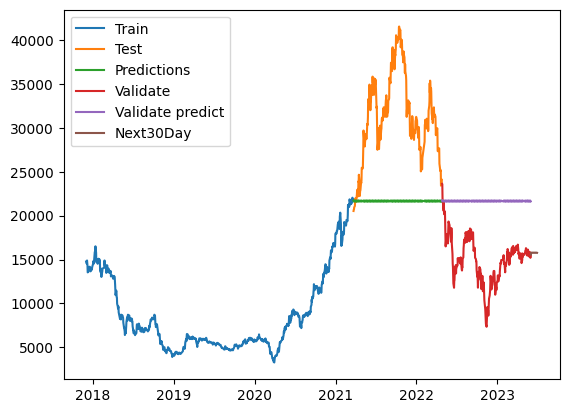

In [19]:
# 9.Vẽ hình
plt.plot(Y_train.index, Y_train)
plt.plot(Y_test.index, Y_test)
plt.plot(Y_test.index, Y_pred)
plt.plot(Y_val.index, Y_val)
plt.plot(Y_val.index, Y_pred_val)
plt.plot(forecast_df['Date'], forecast_df['Close'])
plt.legend(['Train', 'Test', 'Predictions','Validate','Validate predict','Next30Day'])
plt.show()

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



         Date    Close
0  2023-06-03  15475.0
1  2023-06-04  15475.0
2  2023-06-05  15475.0
3  2023-06-06  15475.0
4  2023-06-07  15475.0
5  2023-06-08  15475.0
6  2023-06-09  15475.0
7  2023-06-10  15475.0
8  2023-06-11  15475.0
9  2023-06-12  15475.0
10 2023-06-13  15475.0
11 2023-06-14  15475.0
12 2023-06-15  15475.0
13 2023-06-16  15475.0
14 2023-06-17  15475.0
15 2023-06-18  15475.0
16 2023-06-19  15475.0
17 2023-06-20  15475.0
18 2023-06-21  15475.0
19 2023-06-22  15475.0
20 2023-06-23  15475.0
21 2023-06-24  15475.0
22 2023-06-25  15475.0
23 2023-06-26  15475.0
24 2023-06-27  15475.0
25 2023-06-28  15475.0
26 2023-06-29  15475.0
27 2023-06-30  15475.0
28 2023-07-01  15475.0
29        NaT  15475.0


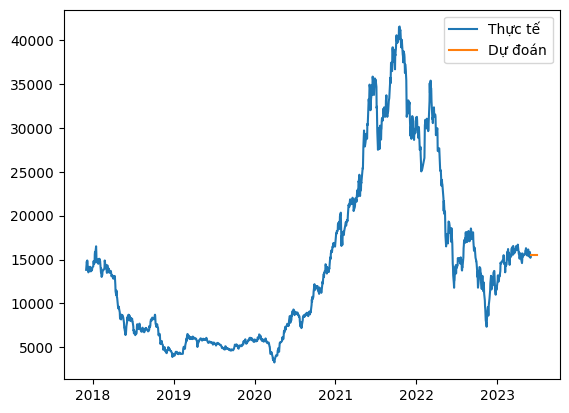

In [20]:

# Xây dựng lại mô hình trên toàn bộ dữ liệu
knn_model = KNeighborsRegressor(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_model.fit(X, Y)

# Dự đoán giá đóng cửa của 30 ngày tiếp theo
last_date = df.index[-1]
forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
forecast_df = pd.DataFrame([(date, 0) for date in forecast_dates], columns=['Date', 'Close'])
last_price = df['Price'].iloc[-1]
for i in range(30):
    pred = knn_model.predict([[last_price]])
    if len(pred) != 1:
        print("Error: Invalid prediction shape.")
        break
    forecast_df.at[i, 'Close'] = pred[0]
    last_price = pred[0]

# In kết quả dự đoán
print(forecast_df)

# Vẽ biểu đồ dự đoán
plt.plot(df.index, df['Price'], label='Thực tế')
plt.plot(forecast_df['Date'], forecast_df['Close'], label='Dự đoán')
plt.legend()
plt.show()